# Testing PA tagged rel04
This notebook is meant to be a demo for creating a rel04 pitch angle tagged product

Features
1. Splitting up counts within the field of view by the response function (DONE)
1. Compute PA for all the points in the split
1. Pixel corrections based on PA distribution matching between pixels
1. energy channel interpolation


## Splitting up counts within the field of view by the response function (DONE)


In [1]:
import ctypes
import ctypes.util
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
import numpy as np
import spacepy.toolbox as tb
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
import spacepy.plot as spp

%matplotlib inline

This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/blarsen/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sc_uvw_rot = np.matrix([[ 0.81915204, -0.57357644,  0.        ],
                            [ 0.57357644,  0.81915204,  0.        ],
                            [-0.        ,  0.        ,  1.        ]])

In [3]:
np.asarray((np.array([0,0,1])*sc_uvw_rot))[0]

array([ 0.,  0.,  1.])

In [4]:
    # 80 degree rotation around z
    hope3_rot = np.matrix([[ 0.98480775,  0.17364818,  0.        ],
                           [-0.17364818,  0.98480775,  0.        ],
                           [ 0.        ,  0.        ,  1.        ]]).transpose()

In [5]:
print(np.rad2deg(np.arccos(hope3_rot[1,1])))
print(np.rad2deg(np.arcsin(hope3_rot[0,0])))


10.0000009939
79.9999990061


In [6]:
np.cos(np.deg2rad(80)), np.sin(np.deg2rad(80))

(0.17364817766693041, 0.98480775301220802)

In [7]:
deg_polar_1 = np.matrix([[ np.cos(np.deg2rad(1)),  np.sin(np.deg2rad(1)),  0.        ],
                           [-np.sin(np.deg2rad(1)),  np.cos(np.deg2rad(1)),  0.        ],
                           [ 0.        ,  0.        ,  1.        ]]).transpose()

In [8]:
newrot = hope3_rot * deg_polar_1
print(newrot)

[[ 0.98162718 -0.190809    0.        ]
 [ 0.190809    0.98162718  0.        ]
 [ 0.          0.          1.        ]]


In [9]:
print(np.rad2deg(np.arccos(newrot[1,1])))
print(np.rad2deg(np.arcsin(newrot[0,0])))

11.0000009166
78.9999990834


In [10]:
np.cos(np.deg2rad(79)), np.sin(np.deg2rad(79))

(0.19080899537654492, 0.98162718344766398)

In [11]:
np.sqrt(3)*np.sqrt(2), np.sqrt(3*2)

(2.4494897427831783, 2.4494897427831779)

In [12]:
def get_g_peak(fwhm, mu):
    return 2*np.sqrt(np.log(2))/(np.sqrt(np.pi)*fwhm) # use this if you want a true gaussian
def g_eq(fwhm, mu, x):
    if len(np.asarray(x)) == 1:
        return mu
    t1 = get_g_peak(fwhm, mu)
#     t1=1
    exp1 = -4*np.log(2)*(x-mu)**2 
    exp2 = fwhm**2
    return t1*np.exp(exp1/exp2)


In [13]:
x = np.linspace(-8, 8, 100)
fwhm = 4.46
mu = -0.86
# curve = np.asarray([g_eq(fwhm, mu, v) for v in x])
curve = g_eq(fwhm, mu, x)
x.shape, curve.shape
peak = get_g_peak(fwhm, mu)

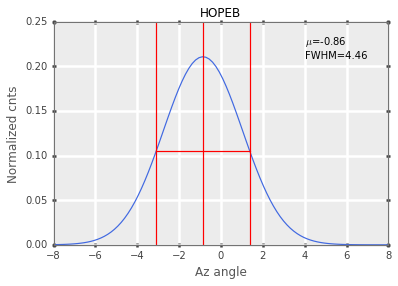

In [14]:
plt.plot(x, curve)
plt.axvline(mu, c='r')
plt.plot([mu-fwhm/2, mu+fwhm/2], [peak/2, peak/2], c='r')
plt.axvline(mu-fwhm/2, c='r')
plt.axvline(mu+fwhm/2, c='r')
plt.xlabel('Az angle')
plt.ylabel('Normalized cnts')
plt.title('HOPEB')
plt.text(4, peak, '$\mu$={0}\nFWHM={1}'.format(mu, fwhm))

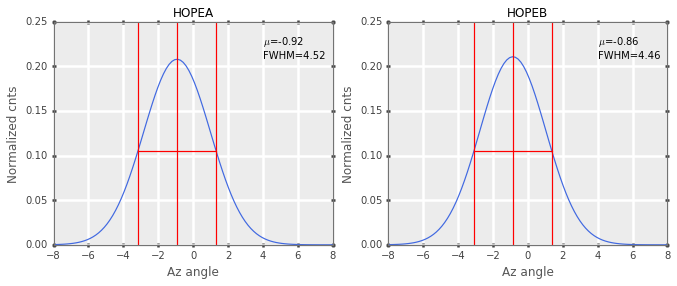

In [15]:
afwhm = 4.52
amu = -0.92
acurve = g_eq(afwhm, amu, x)
bfwhm = 4.46
bmu = -0.86
bcurve = g_eq(bfwhm, bmu, x)

fig=plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(x, acurve)
plt.axvline(amu, c='r')
plt.plot([amu-afwhm/2, amu+afwhm/2],  [peak/2, peak/2], c='r')
plt.axvline(amu-afwhm/2, c='r')
plt.axvline(amu+afwhm/2, c='r')
plt.xlabel('Az angle')
plt.ylabel('Normalized cnts')
plt.title('HOPEA')
plt.text(4, peak, '$\mu$={0}\nFWHM={1}'.format(amu, afwhm))
plt.subplot(122)
plt.plot(x, bcurve)
plt.axvline(bmu, c='r')
plt.plot([bmu-bfwhm/2, bmu+bfwhm/2],  [peak/2, peak/2], c='r')
plt.axvline(bmu-bfwhm/2, c='r')
plt.axvline(bmu+bfwhm/2, c='r')
plt.xlabel('Az angle')
plt.ylabel('Normalized cnts')
plt.title('HOPEB')
plt.text(4, peak, '$\mu$={0}\nFWHM={1}'.format(bmu, bfwhm))






In [16]:
# digitize the data and look for lines
dat = [
-80.19845,68.50645,
-77.915405,71.2337,
-77.44949,74.23647,
-76.53008,76.96558,
-75.61376,78.87559,
-75.6086,80.24077,
-75.59413,84.06326,
-75.13339,85.70086,
-74.669556,88.157555,
-71.48569,88.69928,
-71.48258,89.51839,
-67.41753,82.68692,
-66.06836,78.86256,
-64.26465,75.03758,
-63.360725,73.671165,
-43.362896,73.097786,
-42.445545,75.28083,
-41.528194,77.463875,
-40.608776,80.192986,
-39.236885,82.37541,
-37.404247,86.19542,
-36.94557,87.28694,
-35.571613,90.015434,
-34.216248,87.82929,
-31.063372,80.179955,
-9.278361,71.41303,
-8.366176,72.2309,
-4.2432632,80.689415,
-4.237065,82.32763,
-3.7773566,83.692184,
-1.9509196,85.873985,
-1.0377012,86.96488,
0.7928678,90.23883,
0.33729166,89.966415,
5.753586,79.85666,
5.740156,76.3072,
9.812449,71.38697,
27.995207,71.635185,
30.28032,74.90851,
32.57473,80.63915,
32.587124,83.91557,
33.50241,85.55255,
38.947628,83.08778,
37.14495,87.1858,
41.217247,82.26557,
44.362892,72.70499,
45.267845,71.61161,
62.55081,74.31838,
65.291504,77.86412,
66.21402,81.41234,
68.96297,87.14236,
72.157166,90.41444,
74.41335,86.04277,
75.76045,81.67234,
77.114784,79.213165,
81.62613,70.196785,]
dat = np.asarray(dat).reshape((-1,2))
ind = np.argsort(dat[:,0])
dat = dat[ind]

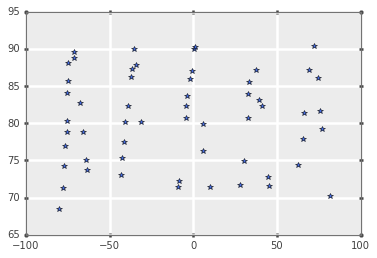

In [17]:
plt.plot(dat[:,0], dat[:,1], '*')

In [18]:
run, rise = dat[8]-dat[0]
rise, run, rise/run

(19.651105000000001, 5.528893999999994, 3.5542560591684382)

In [19]:
np.sqrt(5.5**2 + 20**2)

20.742468512691541

10.0


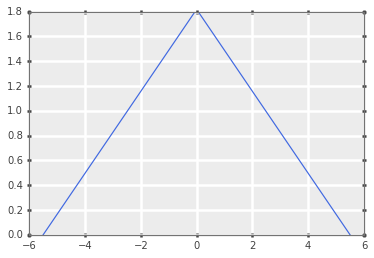

In [20]:
from scipy.integrate import trapz
def dist_tri(counts, deg, width=5.5, height=19.65):
    if (np.min(deg) < -width) or (np.min(deg) > width):
        raise(ValueError())
    area = 0.5 * width*2 * height
    ind = deg < 0
    slope = (height-0)/width
    intercept = slope*width
    y = slope*deg[ind] + intercept
    y = np.append(y, -slope*deg[~ind] + intercept)
    # now we have to scale this until the intergral is counts
    integral = trapz(y, deg)
    # get the scale
    y /= integral
    y *= counts
    return y
    

x = np.linspace(-5.5, 5.5, 100)
y = dist_tri(10, x) 
plt.plot(x, y)
print(trapz(y, x))    

9.99685731685


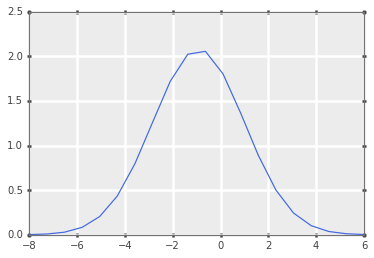

In [21]:
def get_g_peak(fwhm, mu):
    return 2*np.sqrt(np.log(2))/(np.sqrt(np.pi)*fwhm) # use this if you want a true gaussian
def g_eq(fwhm, mu, x):
    t1 = get_g_peak(fwhm, mu)
    exp1 = -4*np.log(2)*(x-mu)**2 
    exp2 = fwhm**2
    return t1*np.exp(exp1/exp2)

def dist_gauss(counts, fwhm, mu, x):
    y = g_eq(fwhm, mu, x)
    return np.asarray(y * counts)
    
x = np.linspace(-8, 6, 20)
y = dist_gauss(10, 4.52, -0.92, x)
print(trapz(y, x))
plt.plot(x, y)

In [22]:
%debug


In [23]:
# can this be done in 2D?

counts = 100
az = np.linspace(-8, 6, 30)
polar = np.linspace(-5.5, 5.5, 20)
out = np.zeros((len(polar), len(az)), dtype=float)
print(out.shape)


(20, 30)


Sum: 357.73592302 should be: 100


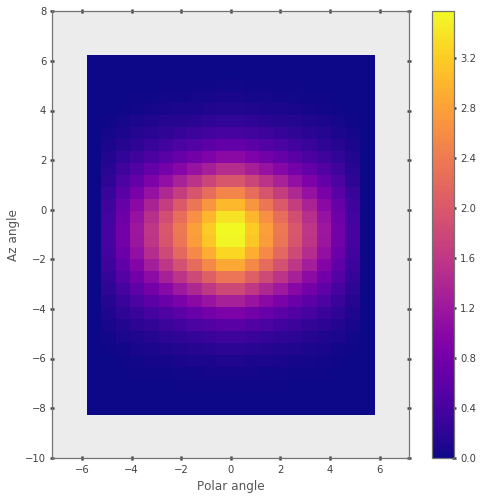

In [24]:
# start with polar split
polar_cnts1 = dist_tri(counts, polar)
# at each polar do the az split
for i, p in enumerate(polar_cnts1):
    az_tmp = dist_gauss(p, afwhm, amu, az)
    out[i] = az_tmp
plt.figure(figsize=(8,8))
plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out.T)
plt.xlabel('Polar angle')
plt.ylabel('Az angle')
plt.axis('equal')

plt.colorbar()
print('Sum:', out.sum(), 'should be:', counts)



az_counts2.sum(): 207.110271222
Sum: 357.73592302


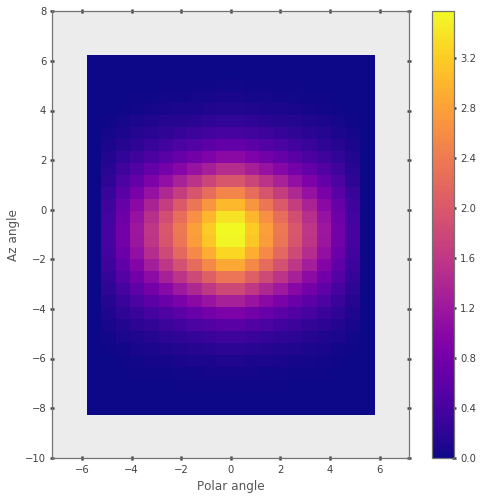

In [25]:
# start with az split
az_counts2 = dist_gauss(counts, afwhm, amu, az)
print('az_counts2.sum():', az_counts2.sum())

# at each polar do the az split
for i, a in enumerate(az_counts2):
    polar_tmp = dist_tri(a, polar)
    out[:,i] = polar_tmp
plt.figure(figsize=(8,8))
plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out.T)
plt.xlabel('Polar angle')
plt.ylabel('Az angle')
plt.axis('equal')

plt.colorbar()
print('Sum:', out.sum())



# Try making sums conserve counts not integrals!


10.0


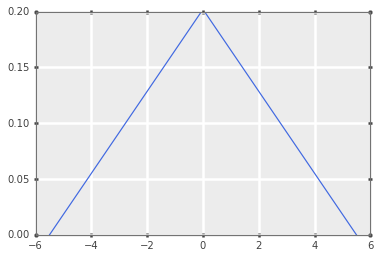

In [26]:
def dist_tri(counts, deg, width=5.5, height=19.65):
    if (np.min(deg) < -width) or (np.min(deg) > width):
        raise(ValueError())
    area = 0.5 * width*2 * height
    ind = deg <= 0
    slope = (height-0)/width
    intercept = slope*width
    y = slope*deg[ind] + intercept
    y = np.append(y, -slope*deg[~ind] + intercept)
    # now we have to scale this until the intergral is counts
    integral = y.sum()
    # get the scale
    y /= integral
    y *= counts
    return y
    

x = np.linspace(-5.5, 5.5, 100)
y = dist_tri(10, x) 
plt.plot(x, y)
print(y.sum())

10.0


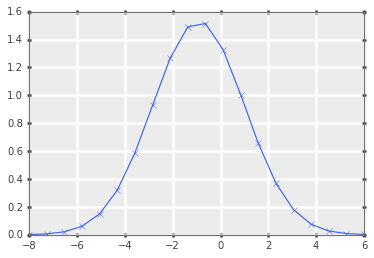

In [27]:
def get_g_peak(fwhm, mu):
    return 2*np.sqrt(np.log(2))/(np.sqrt(np.pi)*fwhm) # use this if you want a true gaussian
def g_eq(fwhm, mu, x):
    t1 = get_g_peak(fwhm, mu)
    exp1 = -4*np.log(2)*(x-mu)**2 
    exp2 = fwhm**2
    return t1*np.exp(exp1/exp2)

def dist_gauss(counts, fwhm, mu, x):
    y = g_eq(fwhm, mu, x)
    y /= y.sum()
    y *= counts    
    return y

x = np.linspace(-8, 6, 20)
y = dist_gauss(10, 4.52, -0.92, x)
print(y.sum())
plt.plot(x, y, 'x-')

In [28]:
# can this be done in 2D?

counts = 100
az = np.linspace(-8, 6, 30)
polar = np.linspace(-5.5, 5.5, 20)
out1 = np.zeros((len(polar), len(az)), dtype=float)
out2 = np.zeros((len(polar), len(az)), dtype=float)
print(out.shape)


(20, 30)


polar_cnts1.sum(): 100.0
Sum: 357.73592302 should be: 100


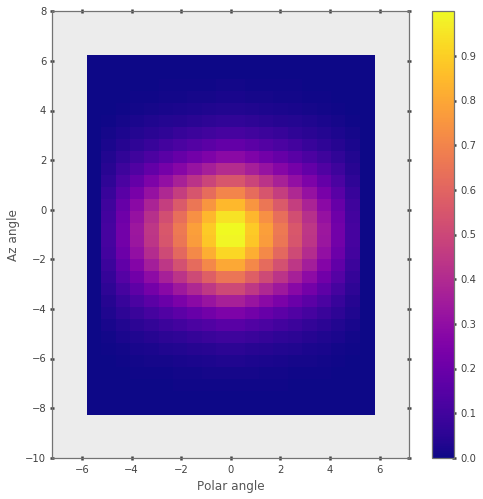

In [29]:
# start with polar split
polar_cnts1 = dist_tri(counts, polar)
print('polar_cnts1.sum():', polar_cnts1.sum())

# at each polar do the az split
for i, p in enumerate(polar_cnts1):
    az_tmp = dist_gauss(p, afwhm, amu, az)
    out1[i] = az_tmp
plt.figure(figsize=(8,8))
plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out1.T)
plt.xlabel('Polar angle')
plt.ylabel('Az angle')
plt.axis('equal')

plt.colorbar()
print('Sum:', out.sum(), 'should be:', counts)



az_counts2.sum(): 100.0
Sum: 357.73592302


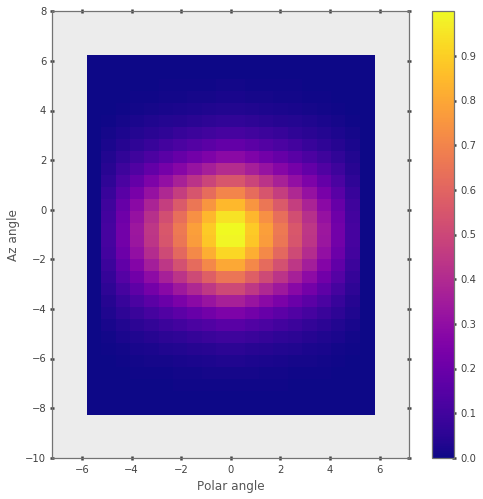

In [30]:
# start with az split
az_counts2 = dist_gauss(counts, afwhm, amu, az)
print('az_counts2.sum():', az_counts2.sum())

# at each polar do the az split
for i, a in enumerate(az_counts2):
    polar_tmp = dist_tri(a, polar)
    out2[:,i] = polar_tmp
plt.figure(figsize=(8,8))
plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out2.T)
plt.xlabel('Polar angle')
plt.ylabel('Az angle')
plt.axis('equal')

plt.colorbar()
print('Sum:', out.sum())



(array([  14.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   20.,    0.,    0.,    0.,    0.,    0.,
          13.,    0.,    0.,   13.,    0.,    8.,   34.,  453.,   15.,
           0.,    9.,    0.,    0.,    9.,    0.,    0.,    0.,    0.,
           0.,    6.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    6.]),
 array([ -1.11022302e-16,  -1.06581410e-16,  -1.02140518e-16,
         -9.76996262e-17,  -9.32587341e-17,  -8.88178420e-17,
         -8.43769499e-17,  -7.99360578e-17,  -7.54951657e-17,
         -7.10542736e-17,  -6.66133815e-17,  -6.21724894e-17,
         -5.77315973e-17,  -5.32907052e-17,  -4.88498131e-17,
         -4.44089210e-17,  -3.99680289e-17,  -3.55271368e-17,
         -3.10862447e-17,  -2.66453526e-17,  -2.22044605e-17,
         -1.77635684e-17,  -1.33226763e-17,  -8.88178420e-18,
         -4.44089210e-18,   0.00000000e+00,   4.44089210e-18,
          8.88178420e-18,   1.33226763e-17

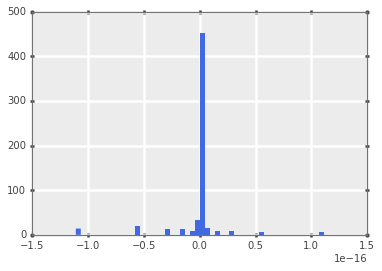

In [31]:
plt.hist((out1 - out2).flatten(), 50)